# MOGP experiment on Finance dataset
## Oil, Gold, NASDAQ, and USD-index dataset

This notebook ilustrate the toolkit use on a real-world finance dataset, taking the weekly price of the Gold, Oil, NASDAQ and USD.

For this 4-output time series we fit three different multioutput Gaussian Processes and show the results.

For each model we optimize we repeat the experiment 5 times, to ensure robustness in the optimization and prediction.


- Oil: Brent daily in USD from https://www.eia.gov/dnav/pet/hist/RBRTEd.htm
- Gold: LMBA gold daily at 10:30AM in USD from https://fred.stlouisfed.org/series/GOLDAMGBD228NLBM
- NASDAQ: adjusted closing price (daily) from https://finance.yahoo.com/quote/%5EIXIC/history?p=%5EIXIC
- USD index: traded weighted on broad currency index from https://fred.stlouisfed.org/series/TWEXB

In [3]:
import sys
sys.path.insert(0, '../')
%reload_ext autoreload
%autoreload 2

import mogptk
import gpflow

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime

# plot config
sns.set_context('paper', font_scale=1.4)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 5)

### Load Dataset

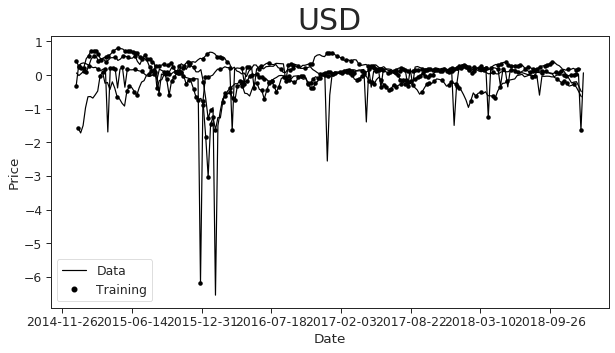

In [13]:
oil = mogptk.LoadCSV('data/gonu/brent-daily.csv',
                     'Date',
                     'Price',
                     names='Oil',
                     format={'Date': mogptk.FormatDate})
gold = mogptk.LoadCSV('data/gonu/lmba-gold-usd-am-daily.csv',
                      'Date',
                      'Price',
                      names='Gold',
                      format={'Date': mogptk.FormatDate})
nasdaq = mogptk.LoadCSV('data/gonu/nasdaq.csv',
                        'Date',
                        'Adj Close',
                        names='NASDAQ',
                        format={'Date': mogptk.FormatDate})
usd = mogptk.LoadCSV('data/gonu/TWEXB.csv',
                     'Date',
                     'Price',
                     names='USD',
                     format={'Date': mogptk.FormatDate})

cols = ['Oil', 'Gold' 'NASDAQ', 'USD']
data = mogptk.DataSet(oil, gold, nasdaq, usd)

# Remove points randomly to simulate sensor failure
np.random.seed(1)
for i, channel in enumerate(data):
    channel.filter('2015-01-01', '2018-12-31')
    channel.aggregate('7d')
    
    channel.transform(mogptk.TransformLog)
    channel.transform(mogptk.TransformDetrend)
    
    if i == 1:
        channel.remove_range('2016-11-15', '2017-01-01')
        channel.remove_randomly(pct=0.6)
    if i == 0:
        channel.remove_range('2018-10-05', None)
        channel.remove_randomly(pct=0.3)
    if i == 2:
        channel.remove_randomly(pct=0.6)
    if i == 3:
        channel.remove_range('2016-03-15', '2016-06-01')
        channel.remove_randomly(pct=0.6)
        
    channel.plot()
    
    x_test, y_test = 

#x_test = [channel.X[~channel.mask] for channel in data]
#y_test = [mogptk.data._detransform(c.transformations, c.X, c.Y)[~c.mask] for c in data]

## MOSM

The first model is the MultiOutput Spectral Mixture kernel

In [12]:
%%time
n_trials = 5

# result containers
mosm_list = []
mosm_mae = np.zeros((n_trials, len(cols)))
mosm_nmae = np.zeros((n_trials, len(cols)))
mosm_rmse = np.zeros((n_trials, len(cols)))
mosm_nrmse = np.zeros((n_trials, len(cols)))

# experiment trials
for n in range(n_trials):
    model_mosm = mogptk.MOSM(data, Q=3)
    model_mosm.estimate_params('BNSE')
    
    print('Starting trial', n)
    model_mosm.train(method='L-BFGS-B', maxiter=5000, tol=1e-50)
    print('='*50)
    
    mosm_list.append(model_mosm)
    
    # errors per channel
    #error = mogptk.test_errors(model_mosm, x_test=x_test, y_test=y_test)
    
    #mosm_mae[n, :] = np.array(error[0])[:, 0]
    #mosm_nmae[n, :] = np.array(error[0])[:, 1]
    #mosm_rmse[n, :] = np.array(error[0])[:, 2]
    #mosm_nrmse[n, :] = np.array(error[0])[:, 3]

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(np.c_[mosm_mae.mean(0), mosm_nmae.mean(0), mosm_rmse.mean(0), mosm_nrmse.mean(0),
                             mosm_mae.std(0), mosm_nmae.std(0), mosm_rmse.std(0), mosm_nrmse.std(0)],
                       columns=['MAE', 'nmae', 'RMSE', 'NRMSE', 'MAE std', 'nmae% std', 'RMSE std', 'NRMSE std'])

Plot the best model

In [ ]:
best_mosm = mosm_list[np.argmin(mosm_nmae.mean(1))]
ylims = [(1150, 1400), (40, 92), (5300, 8300), (114, 131)]
f, axarr, _ = mogptk.plot_prediction(best_mosm,
                       grid=(2, 2),
                       names=cols,
                       title='',
                       ylims=ylims,
                       figsize=(12, 4));

yticks = [(1200, 1350), (50, 80), (5400, 8100), (117, 127)]

for i in range(len(cols)):
    axarr[i].set_title(cols[i], fontsize=15)
    axarr[i].set_yticks(np.linspace(yticks[i][0], yticks[i][1], 3))

    channel = best_mosm.data[i]

    xlabels = pd.date_range('2015-01-01', '2018-12-31', periods=9).date
    xticks = [channel.formatters[0]._parse(str(label)) for label in xlabels]
    
    new_xlabels = ['']*9
    xlabels[::2][2:] += datetime.timedelta(days=1)
    new_xlabels[::2] = xlabels[::2]
    
    axarr[i].set_xticks(xticks)
    
    if i>= 2:
         axarr[i].set_xticklabels(new_xlabels)
        
    else:
         axarr[i].set_xticklabels([])
    axarr[i].set_xlim(xticks[4], xticks[-1])
    
    xlabel_list = [item for item in axarr[i].get_xticklabels()]
    
    
    if i>=2:
        xlabel_list[4].set_ha('left')
        xlabel_list[-1].set_ha('right')

plt.tight_layout()
    
# plt.savefig('output/mosm_gonu.pdf', bbox_inches='tight')

In [ ]:
f, ax, im, corr_matrix = best_mosm.plot_correlations()
ax.set_title('GONU', pad=20)
ax.set_yticks(np.arange(4));
ax.set_yticklabels(cols);
ax.set_xticks(np.arange(4));
ax.set_xticklabels(cols);
# plt.savefig('output/corr_gonu_best.pdf', bbox_inches='tight')

In [ ]:
y_all = [mogptk.data._detransform(c.transformations, c.X, c.Y) for c in best_mosm.data]
y_all_array = np.empty((207, 0))
for y in y_all:
    y_all_array = np.c_[y_all_array, y[:207]]

auto_corr = np.corrcoef(y_all_array.T)

color_range = np.abs(auto_corr).max()

f, ax = plt.subplots()
im = ax.matshow(auto_corr, cmap='coolwarm', vmin=-color_range, vmax=color_range)

ax.set_title('GONU', pad=20)
f.colorbar(im)
for (i, j), z in np.ndenumerate(auto_corr):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='0.9'))

ax.set_yticks(np.arange(4));
ax.set_yticklabels(cols);
ax.set_xticks(np.arange(4));
ax.set_xticklabels(cols);

# plt.savefig('output/autocorr_gonu.pdf', bbox_inches='tight')

In [ ]:
f, axarray = plt.subplots(1, 2, figsize=(8, 5))

color_range = max(np.abs(corr_matrix).max(), np.abs(auto_corr).max())


im = axarray[0].matshow(corr_matrix, cmap='coolwarm', vmin=-color_range, vmax=color_range)
for (i, j), z in np.ndenumerate(corr_matrix):
    axarray[0].text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='0.9'))
axarray[0].set_title('Kernel', y=1.12, fontsize=15)

im = axarray[1].matshow(auto_corr, cmap='coolwarm', vmin=-color_range, vmax=color_range)
ax.set_title('GONU', pad=20)

for (i, j), z in np.ndenumerate(auto_corr):
    axarray[1].text(j, i, '{:0.1f}'.format(z), ha='center', va='center', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='0.9'))
axarray[1].set_title('Empirical', y=1.12, fontsize=15)

axarray[0].set_yticks(np.arange(4));
axarray[0].set_yticklabels(cols, rotation=90, va='center');
axarray[0].set_xticks(np.arange(4));
axarray[0].set_xticklabels(cols);
axarray[0].xaxis.set_ticks_position('top')

axarray[1].set_yticks(np.arange(4));
axarray[1].set_yticklabels(cols, rotation=90, va='center');
axarray[1].set_xticks(np.arange(4));
axarray[1].set_xticklabels(cols);
axarray[1].xaxis.set_ticks_position('top')

# f.colorbar(im, ax=axarray.ravel().tolist())

cbar_ax = f.add_axes([.92, 0.22, 0.023, 0.563])
f.colorbar(im, cax=cbar_ax)

plt.savefig('output/autocorr_double.pdf', bbox_inches='tight')

In [ ]:
corr_list = []

for model in mosm_list:
    _, _, corr = model.plot_correlations();
    corr_list.append(corr)

In [ ]:
corr_array = np.array(corr_list)
color_range = np.abs(corr_array.mean(0)).max()

f, ax = plt.subplots()
im = ax.matshow(corr_array.mean(0), cmap='coolwarm', vmin=-color_range, vmax=color_range)
f.colorbar(im)
for (i, j), z in np.ndenumerate(corr_array.mean(0)):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='0.9'))

ax.set_yticks(np.arange(4));
ax.set_yticklabels(cols);
ax.set_xticks(np.arange(4));
ax.set_xticklabels(cols);
# plt.savefig('output/corr_gonu_mean.pdf', bbox_inches='tight')

## CSM

In [ ]:
%%time
n_trials = 5

csm_mae = np.zeros((n_trials, len(cols)))
csm_nmae = np.zeros((n_trials, len(cols)))
csm_rmse = np.zeros((n_trials, len(cols)))
csm_nrmse = np.zeros((n_trials, len(cols)))
csm_list = []

for n in range(n_trials):
    model_csm = mogptk.CSM(data, Q=3)
    model_csm.init_params('BNSE')
    
    print('Starting trial', n)
    model_csm.train(method='L-BFGS-B', maxiter=5000, tol=1e-15)
    print('Finished trial', n)
    print('='*50)
    csm_list.append(model_csm)
    
    # errors per channel
    error = mogptk.test_errors(model_csm, x_test=x_test, y_test=y_test)
    
    csm_mae[n, :] = np.array(error[0])[:, 0]
    csm_nmae[n, :] = np.array(error[0])[:, 1]
    csm_rmse[n, :] = np.array(error[0])[:, 2]
    csm_nrmse[n, :] = np.array(error[0])[:, 3]

In [ ]:
pd.DataFrame(np.c_[csm_mae.mean(0), csm_nmae.mean(0), csm_rmse.mean(0), csm_nrmse.mean(0),
                             csm_mae.std(0), csm_nmae.std(0), csm_rmse.std(0), csm_nrmse.std(0)],
                       columns=['MAE', 'nmae', 'RMSE', 'NRMSE', 'MAE std', 'nmae% std', 'RMSE std', 'NRMSE std'])

In [ ]:
best_csm = csm_list[np.argmin(csm_nmae.mean(1))]
mogptk.plot_prediction(model_csm,grid=(2, 2),
                       names=cols,
                       title='',
                       figsize=(12, 4));

csm = mogptk.CSM(data, Q=3)
csm.init_params()
csm.train(tol=1e-6, maxiter=2000)
csm.print()

csm.predict()
csm.plot_data()

## SM-LMC

In [ ]:
%%time
n_trials = 5

smlmc_mae = np.zeros((n_trials, len(cols)))
smlmc_nmae = np.zeros((n_trials, len(cols)))
smlmc_rmse = np.zeros((n_trials, len(cols)))
smlmc_nrmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    print('Trial ', n)
    model_smlmc = mogptk.SM_LMC(data, Q=3)
    model_smlmc.init_params('BNSE')
    print('='*50)
    
    model_smlmc.train(method='L-BFGS-B', maxiter=5000, tol=1e-50)
    
    error = mogptk.test_errors(model_smlmc, x_test=x_test, y_test=y_test)
    
    smlmc_mae[n, :] = np.array(error[0])[:, 0]
    smlmc_nmae[n, :] = np.array(error[0])[:, 1]
    smlmc_rmse[n, :] = np.array(error[0])[:, 2]
    smlmc_nrmse[n, :] = np.array(error[0])[:, 3]

In [ ]:
pd.DataFrame(np.c_[smlmc_mae.mean(0), smlmc_nmae.mean(0), smlmc_rmse.mean(0), smlmc_nrmse.mean(0),
                   smlmc_mae.std(0), smlmc_nmae.std(0), smlmc_rmse.std(0), smlmc_nrmse.std(0)],
             columns=['MAE', 'nmae%', 'RMSE', 'NRMSE','MAE std', 'nmae% std', 'RMSE std', 'NRMSE std'])

In [ ]:
mogptk.plot_prediction(model_smlmc,grid=(2, 2),
                       names=cols,
                       title='',
                       figsize=(12, 4));

smlmc = mogptk.SM_LMC(data, Q=3)
smlmc.init_params()
smlmc.train(tol=1e-6, maxiter=2000)
smlmc.print()

smlmc.predict()
smlmc.plot_data()

# IGP
Independent GP with SM kernels

In [ ]:
%%time
n_trials = 5

igp_mae = np.zeros((n_trials, len(cols)))
igp_nmae = np.zeros((n_trials, len(cols)))
igp_rmse = np.zeros((n_trials, len(cols)))
igp_nrmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    print('Trial ', n)
    
    igp_list = []
    
    for i in range(len(cols)):
        model_sm = mogptk.SM(data[i], Q=3)
        model_sm.init_params('BNSE')
        model_sm.train(method='L-BFGS-B', maxiter=5000, tol=1e-50)
        
        igp_list.append(model_sm)
        
        error = mogptk.test_errors(model_sm, x_test=[x_test[i]], y_test=[y_test[i]])
    
        igp_mae[n, i] = np.array(error[0])[:, 0]
        igp_nmae[n, i] = np.array(error[0])[:, 1]
        igp_rmse[n, i] = np.array(error[0])[:, 2]
        igp_nrmse[n, i] = np.array(error[0])[:, 3]
    print('='*50)
    

In [ ]:
f, axarr = plt.subplots(2, 2, sharex=True, figsize=(12, 4))
axarr = axarr.reshape(-1)

for i in range(len(cols)):
    c = igp_list[i].data[0]
    x_train = c.X[c.mask]
    y_train = mogptk.data._detransform(c.transformations, c.X[c.mask], c.Y[c.mask])
    
    x_all = c.X
    y_all = mogptk.data._detransform(c.transformations, c.X, c.Y)
    
    x_pred = c.X
    mean_pred, lower_ci, upper_ci = igp_list[i].predict([x_pred])
    
    axarr[i].plot(x_train[:, 0], y_train, '.k', label='Train', )
    axarr[i].plot(x_all[:, 0], y_all, '--', label='Test', c='gray')

    axarr[i].plot(x_pred[:, 0], mean_pred[0], label='Post.Mean', c=sns.color_palette()[i%10])
    axarr[i].fill_between(x_pred[:, 0].reshape(-1),
                          lower_ci[0],
                          upper_ci[0],
                          label='95% c.i',
                          color=sns.color_palette()[i%10],
                          alpha=0.4)

    axarr[i].set_xlim(x_all[0]-1, x_all[-1])

    # set channels name
    
    axarr[i].set_title(cols[i])

plt.suptitle('IGP', y=1.02)
plt.tight_layout()

## Results

In [ ]:
print(mosm_nmae[:, :].mean(), csm_nmae[:, :].mean(), smlmc_nmae[:, :].mean(), igp_nmae[:, :].mean())

In [ ]:
print(mosm_nmae[:, :].std(), csm_nmae[:, :].std(), smlmc_nmae[:, :].std(), igp_nmae[:, :].std())

In [ ]:
print(mosm_nrmse[:, :].mean(), csm_nrmse[:, :].mean(), smlmc_nrmse[:, :].mean(), igp_nrmse[:, :].mean()

In [ ]:
print(mosm_nrmse[:, :].std(), csm_nrmse[:, :].std(), smlmc_nrmse[:, :].std(), igp_nrmse[:, :].std())

In [ ]:
print('mosm nMAE {:.3e} pm {:.3e} | mosm nRMSE {:.3e} pm {:.3e}'.format(
        mosm_nmae.mean(1).mean(),
        mosm_nmae.mean(1).std(),
        mosm_nrmse.mean(1).mean(),
        mosm_nrmse.mean(1).std(),
    )
     )

In [ ]:
print('csm nMAE {:.3e} pm {:.3e} | csm nRMSE {:.3e} pm {:.3e}'.format(
        csm_nmae.mean(1).mean(),
        csm_nmae.mean(1).std(),
        csm_nrmse.mean(1).mean(),
        csm_nrmse.mean(1).std(),
    )
     )

In [ ]:
print('smlmc nMAE {:.3e} pm {:.3e} | smlmc nRMSE {:.3e} pm {:.3e}'.format(
        smlmc_nmae.mean(1).mean(),
        smlmc_nmae.mean(1).std(),
        smlmc_nrmse.mean(1).mean(),
        smlmc_nrmse.mean(1).std(),
    )
     )

In [ ]:
print('igp nMAE {:.3e} pm {:.3e} | igp nRMSE {:.3e} pm {:.3e}'.format(
        igp_nmae.mean(1).mean(),
        igp_nmae.mean(1).std(),
        igp_nrmse.mean(1).mean(),
        igp_nrmse.mean(1).std(),
    )
     )

In [ ]:
mosm_errors = mogptk.test_errors(*mosm_list, x_test=x_test, y_test=y_test, raw_errors=True)

In [ ]:
mosm_nmae2 = np.zeros(5)
mosm_nrmse2 = np.zeros(5)

for n, error in enumerate(mosm_errors):
    mosm_nmae2[n] = np.abs(error[1][-stop:]).mean() / y_test[1][-stop:].mean()
    mosm_nrmse2[n] = np.sqrt((error[1][-stop:]**2).mean()) / y_test[1][-stop:].mean()
    
print('mosm nMAE {:.3e} pm {:.3e} | mosm nRMSE {:.3e} pm {:.3e}'.format(
        mosm_nmae2.mean(),
        mosm_nmae2.std(),
        mosm_nrmse2.mean(),
        mosm_nrmse2.std(),
    )
     )